### 1. 合并India数据和对应的经纬度数据

In [2]:
import pandas as pd
import matplotlib.pylab as plt
import warnings

%matplotlib inline

warnings.filterwarnings("ignore")

station_day_path = "resource/station_day.csv"
station_day = pd.read_csv(station_day_path)
station_day.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,24/11/2017,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,NaN,NaN
1,AP001,25/11/2017,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,26/11/2017,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
3,AP001,27/11/2017,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
4,AP001,28/11/2017,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate


In [3]:
# 将csv文件通过pandas读进来 此时读入的csv以DataFrame的形式来提供很多帮助
india = pd.read_csv('output/station_day_impute.csv')
geometry = pd.read_csv('resource/stations_with_geo.csv')

# 将StationId对应的地理信息存成map形式
station_geo_map = {}
for i in range(len(geometry['StationId'])):
    station_geo_map[geometry['StationId'][i]] = (geometry['latitude'][i], geometry['longitude'][i])

# 分别查看india和geometry的列有哪些
print(india.columns)
print(geometry.columns)

Index(['Unnamed: 0', 'StationId', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx',
       'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI',
       'AQI_Bucket'],
      dtype='object')
Index(['Unnamed: 0', 'StationId', 'StationName', 'City', 'State', 'Status',
       'latitude', 'longitude'],
      dtype='object')


In [4]:
# 可以发现india的第一列 'Unnamed: 0' 为无用列，使用drop()将其删去
# 其中axis=1是按列删除 axis=0是按行删除。
india = india.drop(india.columns[0], axis=1)
india.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,96.4,Severe
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate


In [5]:
# 合并india和geometry
# 其中geometry部分只需要['StationId', 'latitude', 'longitude']这三列 因此单独取出
# how='inner' 表示inner joint
# on='StationId' 表示两个数据通过StationId来标识连接 此处与数据库sql的表达相近
india_with_geo = pd.merge(india, geometry[['StationId', 'latitude', 'longitude']], how='inner', on='StationId')

# 合并完成 查看合并后带有经纬度信息的india数据
india_with_geo.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,latitude,longitude
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,96.4,Severe,16.515083,80.518167
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate,16.515083,80.518167
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate,16.515083,80.518167
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate,16.515083,80.518167
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate,16.515083,80.518167


In [6]:
# 对于每年每个月的平均值计算，首先先把Date这一列的数据从 str 转成 pandas中用于日期操作的类型 Timestamp
# <class 'pandas._libs.tslibs.timestamps.Timestamp'>
# 此时可以通过 time.year time.month time.day 分别得到年月日的信息
india_with_geo['Date'] = pd.to_datetime(india_with_geo['Date'])
india_with_geo = india_with_geo.set_index('Date')
india_with_geo.head()

,StationId,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,latitude,longitude
Date,,,,,,,,,,,,,,,,,
2017-11-24,AP001,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,96.4,Severe,16.515083,80.518167
2017-11-25,AP001,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate,16.515083,80.518167
2017-11-26,AP001,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate,16.515083,80.518167
2017-11-27,AP001,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate,16.515083,80.518167
2017-11-28,AP001,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate,16.515083,80.518167


### 2. 整理2015-2020每月的平均AQI

In [7]:
def if_contains_year(df, year):
    for i in df.reset_index()['Date']:
        if i.year == year:
            return True

    return False


# 整理出每个站点每年每个月的平均值
# 按地点分类，得到每个地点在19年有数据的月份的平均值
india_with_geo_month_mean_total_2019 = None
# india_with_geo['StationId'].unique将得到StationId出现的所有唯一值 即所有的站点
for station in india_with_geo['StationId'].unique():

    # 对每一个站点进行一次计算
    india_with_geo_station = india_with_geo[india_with_geo['StationId'] == station]
    # 以19年为例，判断station是否有2019年的数据
    if if_contains_year(india_with_geo_station, 2019):
        # 选取属于2019年的数据
        india_with_geo_year = india_with_geo_station.loc['2019']
        # 按照月份进行groupby 计算AQI的平均值
        india_with_geo_month_mean = india_with_geo_year.reset_index().groupby(pd.Grouper(key='Date', axis=0, freq='M'))[
            'AQI'].mean()
        # 将计算得到的平均值 和 StationId整合作为一个 DataFrame
        india_with_geo_month_mean_df = pd.DataFrame({'StationId': [station for i in india_with_geo_month_mean],
                                                     'AQI_Monthly_Mean': india_with_geo_month_mean})
        # 合并到存放之前其他站点月均值的india_with_geo_month_mean_total中
        india_with_geo_month_mean_total_2019 = pd.concat(
            [india_with_geo_month_mean_total_2019, india_with_geo_month_mean_df])

# 最终把每个station的月平均整合，得到所有的2019年station每个月的平均值
india_with_geo_month_mean_total_2019

,StationId,AQI_Monthly_Mean
Date,,
2019-01-31,AP001,218.612903
2019-02-28,AP001,114.464286
2019-03-31,AP001,79.967742
2019-04-30,AP001,78.133333
2019-05-31,AP001,103.619355
...,...,...
2019-08-31,WB013,69.580645
2019-09-30,WB013,68.333333
2019-10-31,WB013,134.116129


In [8]:
# 整理出每个站点每年每个月的平均值
# 合计15-20年的数据
india_with_geo_month_mean_total = None
# india_with_geo['StationId'].unique将得到StationId出现的所有唯一值 即所有的站点
for station in india_with_geo['StationId'].unique():
    # 对每一个站点进行一次计算
    india_with_geo_station = india_with_geo[india_with_geo['StationId'] == station]
    for year in ['2015', '2016', '2017', '2018', '2019', '2020']:
        if if_contains_year(india_with_geo_station, int(year)):
            # 选取属于2019年的数据
            india_with_geo_year = india_with_geo_station.loc[year]
            # 按照月份进行groupby 计算AQI的平均值
            india_with_geo_month_mean = \
                india_with_geo_year.reset_index().groupby(pd.Grouper(key='Date', axis=0, freq='M'))[
                    'AQI'].mean()
            # 将计算得到的平均值 和 StationId整合作为一个 DataFrame
            india_with_geo_month_mean_df = pd.DataFrame({'StationId': [station for i in india_with_geo_month_mean],
                                                         'AQI_Monthly_Mean': india_with_geo_month_mean})
            # 合并到存放之前其他站点月均值的india_with_geo_month_mean_total中
            india_with_geo_month_mean_total = pd.concat([india_with_geo_month_mean_total, india_with_geo_month_mean_df])

# 最终把每个station的月平均整合，得到所有的2019年station每个月的平均值
print(india_with_geo_month_mean_total)

           StationId  AQI_Monthly_Mean
Date                                  
2017-11-30     AP001        171.628571
2017-12-31     AP001        194.129032
2018-01-31     AP001        172.451613
2018-02-28     AP001        107.035714
2018-03-31     AP001         80.264516
...              ...               ...
2020-03-31     WB013        155.258065
2020-04-30     WB013         72.366667
2020-05-31     WB013         92.254610
2020-06-30     WB013         45.433333
2020-07-31     WB013         59.000000

[3691 rows x 2 columns]


(66.72480316162121, 98.87660675048834, 5.3169019937514665, 36.938685107231144)

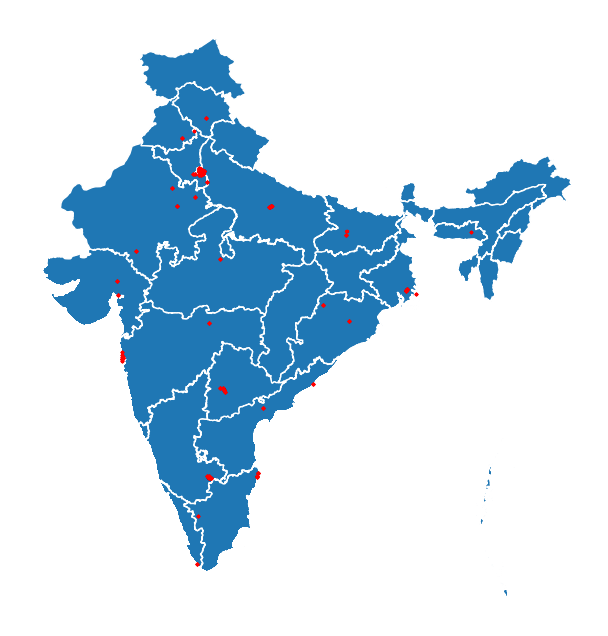

In [9]:
import geopandas as gpd
from pyproj import CRS

CRS_4326 = CRS('epsg:4326')

india_with_geo_month_mean_2019 = india_with_geo_month_mean_total.loc['2019']
india_with_geo_month_mean_2019['latitude'] = india_with_geo_month_mean_2019['StationId'].apply(
    lambda x: station_geo_map[x][0])
india_with_geo_month_mean_2019['longitude'] = india_with_geo_month_mean_2019['StationId'].apply(
    lambda x: station_geo_map[x][1])

latitude = india_with_geo_month_mean_2019.latitude
longitude = india_with_geo_month_mean_2019.longitude
india_with_geo_month_mean_2019_gdf = gpd.GeoDataFrame(india_with_geo_month_mean_2019,
                                                      geometry=gpd.points_from_xy(longitude, latitude), crs=CRS_4326)

fig, ax = plt.subplots(figsize=(8, 8))
india = gpd.read_file('shp/IND_adm1.shp')
india.plot(ax=ax)
india_with_geo_month_mean_2019_gdf.plot(markersize=2, ax=ax,
                                        color='red')
ax.axis('off')

### 3. 平稳性与白噪声检验

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

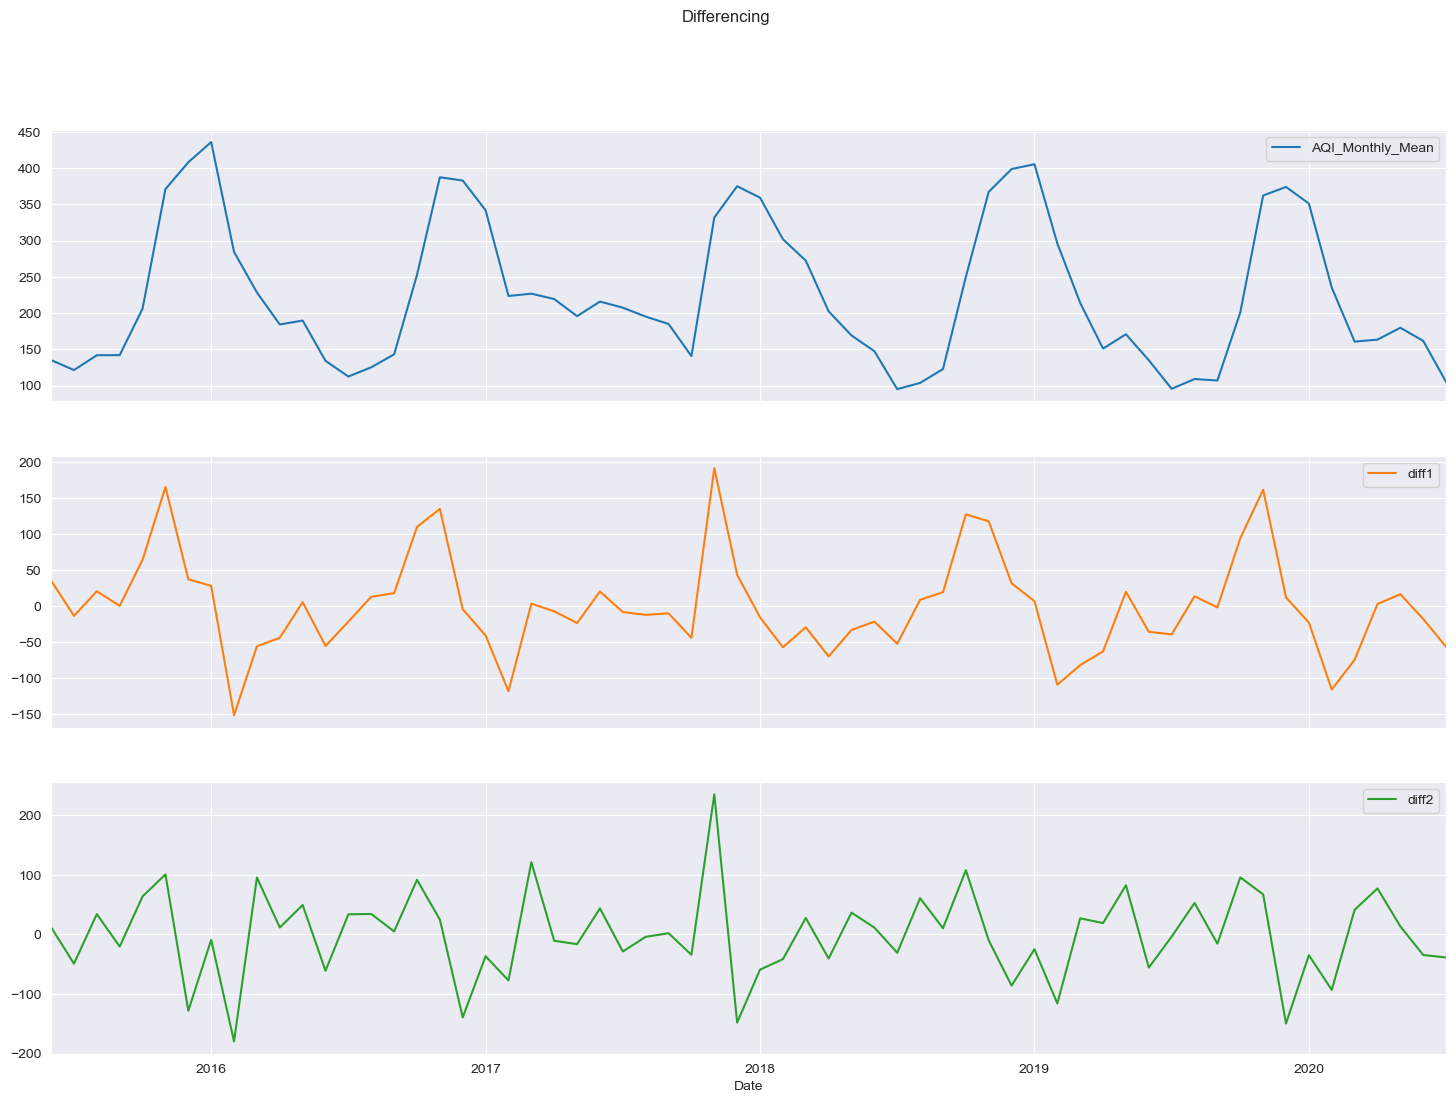

In [10]:
# 平滑处理：差分法
# ARIMA需要时间序列满足平稳性和非白噪声的要求
india_with_geo_month_mean_total["diff1"] = india_with_geo_month_mean_total["AQI_Monthly_Mean"].diff(1)
india_with_geo_month_mean_total["diff2"] = india_with_geo_month_mean_total["diff1"].diff(1)

data1 = india_with_geo_month_mean_total.loc[:, ['StationId', "AQI_Monthly_Mean", "diff1", "diff2"]]
data1 = data1[data1['StationId'] == 'BR007']
data1.plot(subplots=True, figsize=(18, 12), title="Differencing")

In [11]:
import statsmodels.tsa.api as smt
import seaborn as sns

sns.set(style='ticks', context='poster')

# data = data1['diff2'].dropna()

data = india_with_geo[india_with_geo['StationId'] == 'BR007']
data["diff1"] = data['AQI'].diff(1)
data["diff2"] = data['diff1'].diff(1)
data = data['diff2'].dropna()

print(data)


Date
2015-06-03   -74.8
2015-06-04    54.6
2015-06-05   -82.0
2015-06-06    96.4
2015-06-07    -9.4
              ... 
2020-06-27     7.0
2020-06-28    -4.0
2020-06-29    11.0
2020-06-30   -10.0
2020-07-01    -2.0
Name: diff2, Length: 1856, dtype: float64


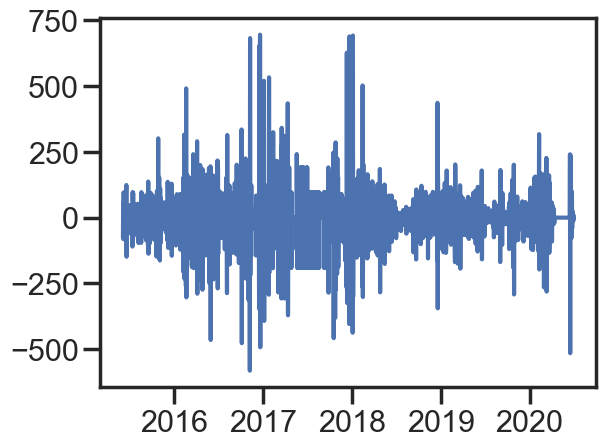

In [12]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plt.plot(data.index, data)
# plt.show()

In [13]:
# 平稳性检验
train = data.loc[:'2020/1/1']
test = data.loc['2020/1/2':]

# 1%、%5、%10不同程度拒绝原假设的统计值和ADF比较
# ADF同时小于1%、5%、10%即说明非常好地拒绝该假设
# 本数据中，adf结果为-1.25， 小于三个level的统计值，说明数据是平稳的
print(sm.tsa.stattools.adfuller(train))

(-15.98278594605528, 6.806100502565864e-29, 25, 1648, {'1%': -3.434324220222672, '5%': -2.8632953907266665, '10%': -2.5677045294237204}, 18256.15427879639)


In [14]:
# 白噪声检验
# acorr_ljungbox(train,lags=[6,12], boxpierce=True)
p_value = acorr_ljungbox(train, lags=1)
p_value

# 各阶延迟下LB和BP统计量的P值都小于显著水平0.05,
# 所以拒绝序列为纯随机序列的原假设，认为该序列为非白噪声序列

,lb_stat,lb_pvalue
1,580.529222,2.877161e-128


### 4. ACF与PACF计算

Text(0.5, 1.0, 'ACF')

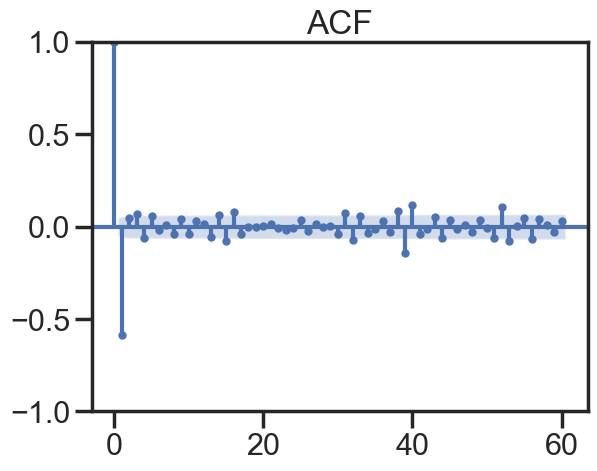

In [15]:
# 计算ACF
acf = plot_acf(train, lags=60)  # lags=10为往后滞后10个点，即下图中1+10=11个点
plt.title('ACF')

Text(0.5, 1.0, 'PACF')

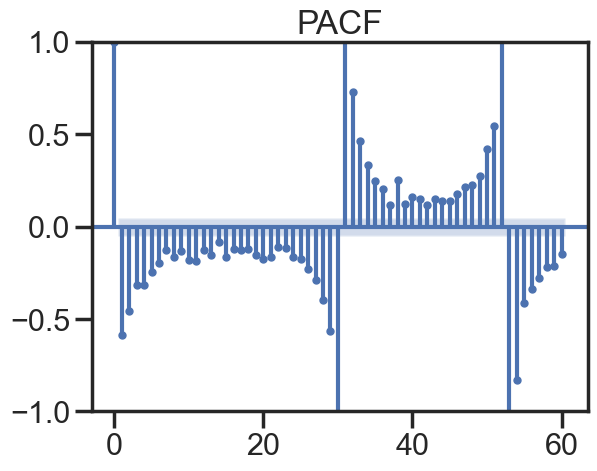

In [16]:
# PACF
smt.graphics.plot_pacf(train, lags=60)
plt.title("PACF")

/Users/chenxingyang/.conda/envs/windFarmSelection/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chenxingyang/.conda/envs/windFarmSelection/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chenxingyang/.conda/envs/windFarmSelection/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chenxingyang/.conda/envs/windFarmSelection/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chenxingyang/.conda/envs/windFarm

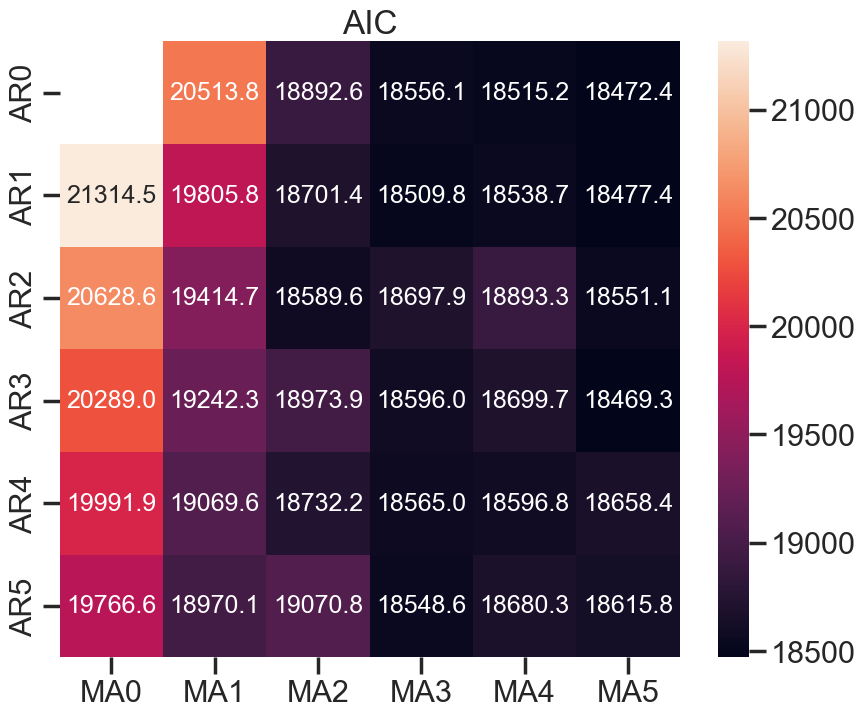

In [17]:
import itertools
import numpy as np


def heatmap_AIC(timeseries):
    #设置遍历循环的初始条件，以热力图的形式展示
    p_min = 0
    q_min = 0
    p_max = 5
    q_max = 5
    d_min = 0
    d_max = 1
    # 创建Dataframe,以AIC准则
    results_aic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min, p_max + 1)], \
                               columns=['MA{}'.format(i) for i in range(q_min, q_max + 1)])
    # itertools.product 返回p,q中的元素的笛卡尔积的元组
    for p, d, q in itertools.product(range(p_min, p_max + 1), range(d_min, d_max + 1), range(q_min, q_max + 1)):
        if p == 0 and q == 0:
            results_aic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
            continue
        try:
            model = sm.tsa.ARIMA(timeseries, order=(p, d, q))
            results = model.fit()
            #返回不同pq下的model的AIC值
            results_aic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.aic
        except:
            continue
    results_aic = results_aic[results_aic.columns].astype(float)
    #print(results_bic)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(results_aic,
                     #mask=results_aic.isnull(),
                     ax=ax,
                     annot=True,  # 将数字显示在热力图上
                     annot_kws={"fontsize": 18},  # 调整字体大小
                     fmt='.1f'
                     )
    ax.set_title('AIC')


heatmap_AIC(train)

### 5. 模型预测

In [18]:
# 从上面热力图看出 (AR2, MA5) (AR4, MA5) (AR5, MA5) => 其中AR对应p MA对应q 下面式子中
# 最终为何确定为(2, 0, 5) 可根据后面对模型进行评估来做比较，(2, 0, 5)的时候表现最佳
model = sm.tsa.arima.ARIMA(train, order=(3, 0, 5))  # order对应的参数为（p, d, q）
arima_res = model.fit()
arima_res.summary()

/Users/chenxingyang/.conda/envs/windFarmSelection/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chenxingyang/.conda/envs/windFarmSelection/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chenxingyang/.conda/envs/windFarmSelection/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chenxingyang/.conda/envs/windFarmSelection/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  diff2   No. Observations:                 1674
Model:                 ARIMA(3, 0, 5)   Log Likelihood               -9251.383
Date:                Sun, 12 Mar 2023   AIC                          18522.767
Time:                        16:01:51   BIC                          18576.996
Sample:                    06-03-2015   HQIC                         18542.858
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.507e-05      0.002      0.049      0.961      -0.003       0.004
ar.L1         -1.8930      0.058    -32.918      0.000      -2.006      -1.780
ar.L2         -1.8454      0.065    -28.522      0.000      -1.972      -1.719
ar.L3         -0.8522      0.056    -15.184      0.000      -0.962      -0.742
ma.L1          0.3035      0.055      5.498      0.000       0.195       0.412
ma.L2         -0.6352      0.035    -18.116      0.000      -0.704      -0.567
ma.L3         -0.9945      0.027    -37.043      0.000      -1.047      -0.942
ma.L4         -0.2539      0.051     -4.933      0.000      -0.355      -0.153
ma.L5          0.5822      0.029     19.933      0.000       0.525       0.639
sigma2      4076.4397    115.196     35.387      0.000    3850.659    4302.220
===================================================================================
Ljung-Box (L1) (Q):                  12.82   Jarque-Bera (JB):              1772.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

182
182


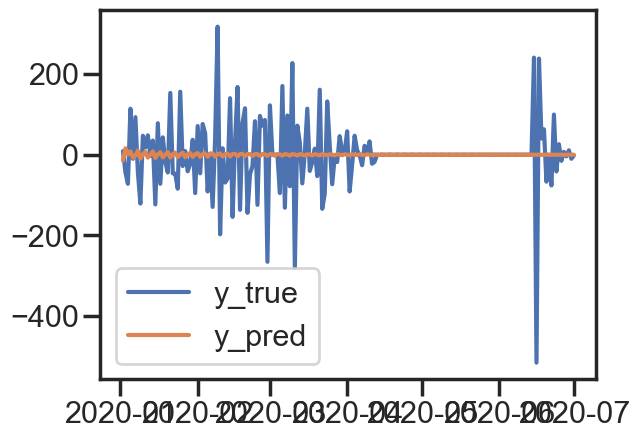

In [19]:
# 模型预测
predict = arima_res.predict('2020/1/2', '2020/7/1')
print(len(predict))
print(len(test))
plt.plot(test.index, test)
plt.plot(test.index, predict)
plt.legend(['y_true', 'y_pred'])
plt.show()

### 6. 模型评价

In [20]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mean_absolute_error(test, predict)
mean_squared_error(test, predict)
print('Mean absolute error', mean_absolute_error(test, predict))
print('Root mean square error', np.sqrt(mean_squared_error(test, predict)))
print('MAPE:', mean_absolute_percentage_error(test.ravel(), predict) * 100)



Mean absolute error 48.9505320166769
Root mean square error 86.1466797548719


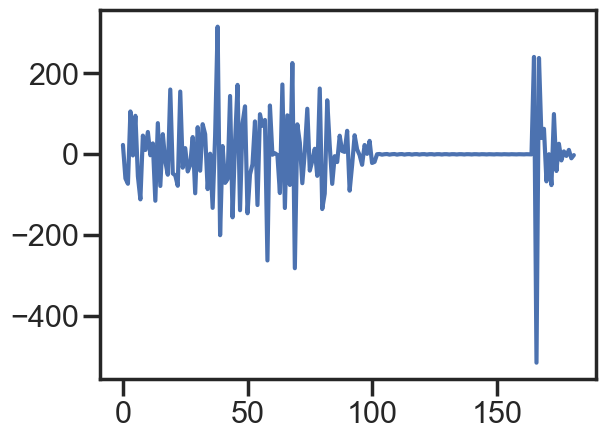

In [21]:
# 残差分析

res = test - predict
residual = list(res)
plt.plot(residual)


In [22]:
import numpy as np

# 查看残差的均值是否在0附近
np.mean(residual)

-0.02919177144359477

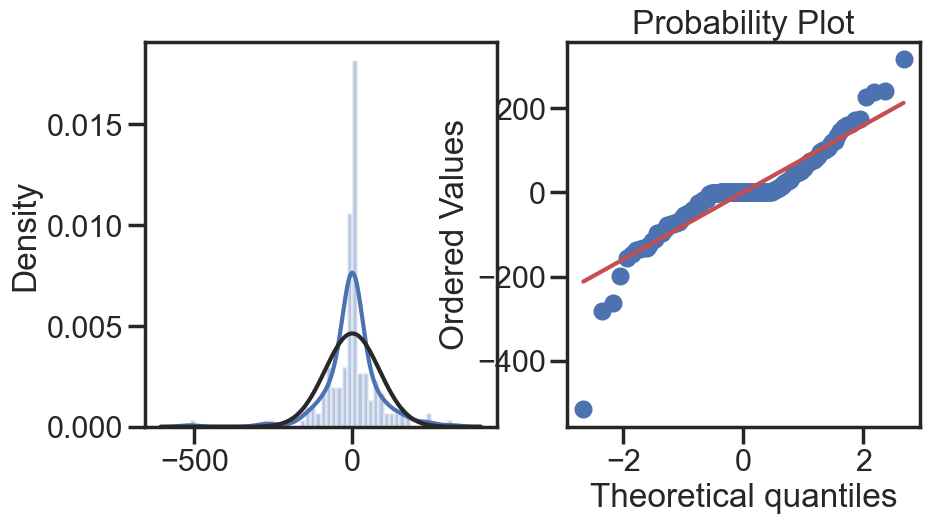

In [23]:
import seaborn as sns
from scipy import stats

# 残差正态性检验
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
sns.distplot(residual, fit=stats.norm)
ax = plt.subplot(1, 2, 2)
res = stats.probplot(residual, plot=plt)


25965


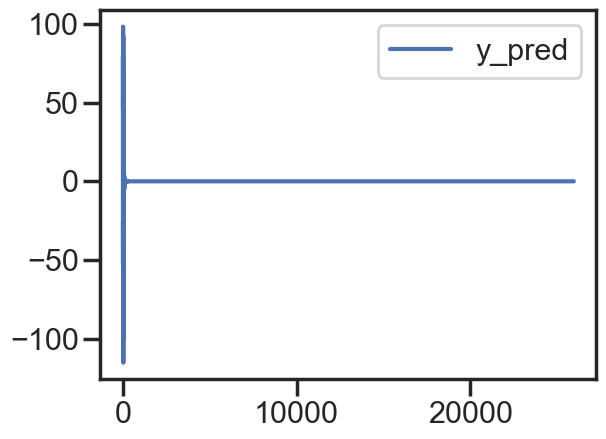

In [24]:
predict = arima_res.predict('2019/12/1', '2091/1/1')

# ARIMA不适用长期预测
# 如果将预测的时间调长，可以发现后面的预测值ARIMA基本都用均值来填充了
plt.plot(range(len(predict)), predict)
plt.legend(['y_pred'])
print(len(predict))

### 7. 神经网络 ANN

In [48]:
from sklearn.neural_network import MLPRegressor, MLPClassifier

# 建立神经网络模型
mlp_model = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 10, 10), random_state=1)

In [79]:
from sklearn.model_selection import train_test_split
x_columns = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
target_label = 'AQI'

data = india_with_geo[india_with_geo['StationId']=='BR007']

train = data.loc[:'2020/1/1']
test = data.loc['2020/1/2':]
#
#     transfer = MinMaxScaler(feature_range=(0, 1))
#
#     # normalization
#     df_x = transfer.fit_transform(df_x)

# 不用train_test_split的原因

x_train = train[x_columns]
y_train = train[target_label]
x_test = test[x_columns]
y_test = test[target_label]

print(len(x_train), len(x_test))

1676 182


In [80]:
# 调用fit函数就可以进行模型训练，一般的调用模型函数的训练方法都是fit()
mlp_model.fit(x_train, y_train)  # 训练

mlp_model

MLPRegressor(alpha=1e-05, hidden_layer_sizes=(10, 10, 10), random_state=1,
             solver='lbfgs')

182
182


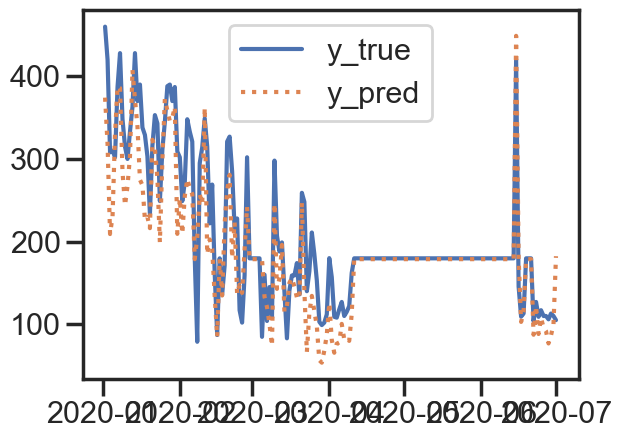

In [96]:
y_predict = mlp_model.predict(x_test)  # 预测

plt.plot(y_test.index, y_test)
plt.plot(y_test.index, y_predict, ':')
plt.legend(['y_true', 'y_pred'])

In [101]:
# print('训练集的层数为：', mlp_model.n_layers_)
# print('训练集的迭代次数', mlp_model.n_iter_)
# print('训练集的代价值是：', mlp_model.loss_)
# print('输出激活函数的名称', mlp_model.out_activation_)

print('r2：', mlp_model.score(x_test, y_test.ravel()))
print('Root mean square error', np.sqrt(mean_squared_error(y_test.ravel(), y_predict)))
print('Mean absolute error', mean_absolute_error(y_test.ravel(), y_predict))
print('MAPE:', mean_absolute_percentage_error(y_test.ravel(), y_predict) * 100)

训练集的准确率是： 0.7677865833478908
训练集的层数为： 5
训练集的迭代次数 200
训练集的代价值是： 1113.8861644825865
输出激活函数的名称 identity
Root mean square error 40.958747670676246
Mean absolute error 26.318471175317946
MAPE: 13.598954281368394
